# Pip Installs


In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 4.05 s (started: 2023-03-18 15:51:08 +00:00)


In [ ]:
!pip install neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.15 s (started: 2023-03-18 15:53:45 +00:00)


In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.05 s (started: 2023-03-18 15:51:15 +00:00)


In [ ]:
pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.76 s (started: 2023-03-18 15:51:18 +00:00)


In [ ]:
pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.94 s (started: 2023-03-18 15:51:22 +00:00)


In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.94 s (started: 2023-03-18 15:51:25 +00:00)


# Imports

In [ ]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
tf.__version__
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# Neu
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras

import tensorflow_privacy



time: 1.72 ms (started: 2023-03-18 15:52:01 +00:00)


In [ ]:
from tensorflow.python.client import device_lib

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
time: 2.03 ms (started: 2023-03-18 15:52:01 +00:00)


In [ ]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.97 ms (started: 2023-03-18 15:52:01 +00:00)


# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/MyDrive/Masterarbeit/Transformer/data/WESAD"

Mounted at /content/drive
S10  S11  S13  S14  S15  S16  S17  S2  S3  S4  S5  S6  S7  S8  S9
time: 28.9 s (started: 2023-03-18 15:32:05 +00:00)


In [ ]:
DATA_PATH = os.path.realpath("/content/drive/MyDrive/Masterarbeit/Transformer/data/WESAD")
#DATA_PATH = os.chdir("/content/drive/MyDrive/Masterarbeit/Transformer/data/WESAD")
checkpoint_prepath = os.path.realpath("/content/drive/MyDrive/Masterarbeit/Transformer/code/models/")


time: 3.3 ms (started: 2023-03-18 15:32:34 +00:00)


In [ ]:
class Subject:
    """Subject of the WESAD dataset.
    Subject Class inspired by: https://github.com/WJMatthew/WESAD"""

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        """Returns data measured by the E4 Empatica"""

        data = self.data['signal']['wrist']
        return data
    
    def get_subject_dataframe(self):
        """Returns a dataframe with the preprocessed data of the subject"""
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        df = (df-df.min())/(df.max()-df.min()) # Normalize data (no train test leakage since data frame per subject) 
        return df


time: 6.23 ms (started: 2023-03-18 15:32:34 +00:00)


In [ ]:
s2 = Subject(DATA_PATH, 2)

time: 14.9 s (started: 2023-03-18 15:32:34 +00:00)


In [ ]:
s2.get_subject_dataframe()

BVP       EDA     ACC_x     ACC_y     ACC_z      TEMP  label
0       0.536850  0.993856  0.661565  0.717624  0.545219  0.950902    0.0
1       0.548782  0.995152  0.676264  0.736944  0.507794  0.950913    0.0
2       0.560715  0.996392  0.683334  0.736449  0.507154  0.950923    0.0
3       0.571374  0.997521  0.691702  0.691200  0.545094  0.950932    0.0
4       0.580215  0.998489  0.674626  0.642324  0.583283  0.950940    0.0
...          ...       ...       ...       ...       ...       ...    ...
135739  0.533648  0.089840  0.499794  0.927696  0.460655  0.441595    0.0
135740  0.536857  0.089739  0.500468  0.929406  0.464332  0.441532    0.0
135741  0.540788  0.089649  0.503081  0.929464  0.466159  0.441435    0.0
135742  0.544653  0.089569  0.504822  0.929406  0.464332  0.441301    0.0
135743  0.548054  0.089500  0.503304  0.929665  0.462674  0.441131    0.0

[135744 rows x 7 columns]

time: 2.88 s (started: 2023-03-18 15:32:49 +00:00)


In [ ]:
def create_subjects_data() -> dict:
    # Create a dictionary with all the subjects and belonging dataframes
    subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    subjects_data = {}
    for subject_num in subjects:
        subject = Subject(DATA_PATH, subject_num)
        subjects_data[subject.name] = subject.get_subject_dataframe()

    return subjects_data

time: 1.3 ms (started: 2023-03-18 15:32:52 +00:00)


### Window

1. Creating the windows
2. Create subwindows from the windows
3. Calculate the fft of the subwindows
4. Average the subwindows

![fft](../images/fft.png)

In [ ]:
# Subwindow length of the biosignals
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

time: 729 µs (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

time: 573 µs (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
def create_windows(df: pd.DataFrame) -> tuple([pd.DataFrame,list]):
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame

    Returns:
        tuple[pd.DataFrame,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

time: 972 µs (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.

    Returns:
        list: Subwindows of the signal in the window.
    """
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

time: 1.49 ms (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)
    

time: 3.28 ms (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
def average_window(subwindows_fft: list) -> list:
    """Calculates the average of the fft coefficients of the subwindows.

    Args:
        subwindows_fft (list): List of fft coefficients of the subwindows.

    Returns:
        list: Average of the fft coefficients of the subwindow for signals.
    """
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

time: 1.41 ms (started: 2023-03-18 15:32:52 +00:00)


In [ ]:
def create_preprocessed_subjects_data(subjects_data: dict) -> dict:
# Creates averaged windows for all subjects from dataframes

    subjects_preprosessed_data = {}
    for subject_name, subject_df in subjects_data.items():
        subjects_preprosessed_data[subject_name] = {}
        windows, labels = create_windows(subject_df)
        yfs_per_min_for_signal = {}
        X = []
        for i in range(0,len(windows) - 1):
            for signal in signal_subwindow_dict.keys():

                duration_in_sec = signal_subwindow_dict[signal]

                subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
                freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
                yfs_average = average_window(yfs)[:210]
                yfs_per_min_for_signal[signal] = yfs_average
                
            X.append(pd.DataFrame(yfs_per_min_for_signal).T)
        y = list(labels[:len(windows)-1])
        subjects_preprosessed_data[subject_name]['X'] = X
        subjects_preprosessed_data[subject_name]['y'] = y
    
    return subjects_preprosessed_data


time: 2.25 ms (started: 2023-03-18 15:37:22 +00:00)


In [ ]:
subjects_data = create_subjects_data()
subjects_preprocessed_data = create_preprocessed_subjects_data(subjects_data)

time: 4min 4s (started: 2023-03-18 15:37:26 +00:00)


In [ ]:
subjects_preprocessed_data

{'S2': {'X': [               0          1          2          3          4          5    \
   ACC_x   233.762562  15.535953  10.130088   7.945010   6.104674   4.953309   
   ACC_y   305.514390   9.329607   6.147158   4.301754   3.431085   2.874462   
   ACC_z   278.898421  19.054440  10.487278   7.526023   5.358748   4.055586   
   BVP    1078.224943  34.248831  29.096366  27.518396  26.491395  25.767258   
   EDA    1441.261510  51.228271  36.207475  32.082962  26.946748  24.045022   
   TEMP   2129.589828   6.461176   3.174824   2.644083   2.320224   2.099558   
   
                6          7          8          9    ...       200       201  \
   ACC_x   4.244127   3.515086   2.961555   2.565385  ...  0.061294  0.061222   
   ACC_y   2.565199   2.244888   1.995886   1.769524  ...  0.037285  0.037248   
   ACC_z   3.372727   2.817283   2.443435   2.109453  ...  0.056662  0.056598   
   BVP    24.604704  23.387339  22.153730  21.055625  ...  0.778253  0.765725   
   EDA    21.265518 

time: 3.16 s (started: 2023-03-18 15:41:31 +00:00)


In [ ]:
def get_subject_window_data(subjects_preprosessed_data: dict) -> tuple([list, list]):
    # Created train and test data for leave one out cross validation
    all_subjects_X = []
    all_subjects_y = []
    for subject_name, subject_data in subjects_preprosessed_data.items():
        all_subjects_X.append(subject_data['X'])
        all_subjects_y.append(subject_data['y'])
    
    return (all_subjects_X, all_subjects_y)


time: 1.61 ms (started: 2023-03-18 15:41:34 +00:00)


In [ ]:
all_subjects_X, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)

time: 460 µs (started: 2023-03-18 15:41:34 +00:00)


![OS_Sensors](../images/os_sensors.png)

In [ ]:
SMARTWATCH_OS = {
    'E4': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'],
    #'Tizen': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'BVP'],
    #'WearOS_watchOS': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP'],
    #'Fitbit': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA'],
    #'PiaOS': ['TEMP', 'EDA', 'BVP']
    }

time: 662 µs (started: 2023-03-18 15:41:34 +00:00)


In [ ]:
def filter_for_smartwatch_os(smartwatch_os_name: str, all_subjects_X: list) -> list:
    # Adjusts the data for the smartwatch os
    all_subjects_X_adjusted_for_smartwatch_os = []
    for subject_data in all_subjects_X:
        subject_adjusted_for_smartwatch_os = []
        for window in subject_data:
            subject_adjusted_for_smartwatch_os.append(window.loc[SMARTWATCH_OS[smartwatch_os_name]])
        all_subjects_X_adjusted_for_smartwatch_os.append(subject_adjusted_for_smartwatch_os)
    return all_subjects_X_adjusted_for_smartwatch_os


time: 987 µs (started: 2023-03-18 15:41:34 +00:00)


# Transformer Model

## Build Model

### Transformer Model


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

time: 1.68 ms (started: 2023-03-18 15:41:34 +00:00)


In [ ]:
def build_model(
   input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout,
    mlp_dropout
):

    inputs = keras.Input(input_shape)
    x = inputs
    #layers.LSTM(1)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_output_class, activation="sigmoid")(x)
    #outputs = layers.Dense(num_output_class, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)
    #model

time: 1.63 ms (started: 2023-03-18 15:41:34 +00:00)


In [ ]:
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise as tfp_computer_noise

"""
Calculate noise for given training hyperparameters
"""
def compute_noise(n, batch_size, target_epsilon, epochs, delta, min_noise=1e-5):
  return tfp_computer_noise(n, batch_size, target_epsilon, epochs, delta, min_noise)

"""
Calculate Delta for given training dataset size n
"""
def compute_delta(n):
# delta should be one magnitude lower than inverse of training set size: 1/n
# e.g. 1e-5 for n=60.000
# take 1e-x, were x is the magnitude of training set size
  delta = np.power(10, - float(len(str(n)))) # remove all trailing decimals
  return delta

time: 2.65 ms (started: 2023-02-26 15:33:17 +00:00)


## Hyperparameter Tracking

In [ ]:
import neptune

run = neptune.init_run( api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmNDZjODdkNS1hMGQzLTQ1M2QtYTBhNy03Y2VlYTU2ZWIzZTkifQ==", project="boris/stresstransformer")
from neptune.new.integrations.tensorflow_keras import NeptuneCallback


neptune_callback = NeptuneCallback(run=run, log_model_diagram=True)
# params = {'num_transformer_blocks':4, 
#           'min_delta_loss':0.001, 
#           'epochs':200,
#           'batch_size':50,
#           'lr':0.0001,
#           'momentum':0.4,
#           'mlp_dropout':0.4,
#           'dropout':0.25,
#           'num_heads':4,
#           'ff_dim':4,
#           'head_size':256,
#            'dp_selected':1,
#            'l2_norm_clip':1.5,
#            'noise_multiplier':1.3,
#            'num_microbatches':1
#           }
params = {'num_transformer_blocks':8, 
          'min_delta_loss':0.01, 
          'epochs':110,
          'batch_size':50,
          'lr':0.0001,
          'mlp_dropout':0.25,
          'dropout':0.25,
          'num_heads':4,
          'ff_dim':4,
          'head_size':256,
          'dp_selected':0,
          'l2_norm_clip':2.0,
          'noise_multiplier':68.61306896515201,
          'num_microbatches':1
          }

run['hyper-parameters'] = params

if params["batch_size"] % params["num_microbatches"] != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

ModuleNotFoundError: ignored

time: 21 ms (started: 2023-03-18 15:54:05 +00:00)


## Model training

In [ ]:
# create an empty dictionary to store the number of epochs
epochs_dict = {}
max_epochs = 0
tf.random.set_seed(42)

for os, signals in SMARTWATCH_OS.items():
  with tf.device('/device:GPU:0'):
    print(f'\n\n\nSmartwatchOS: {os} - Signals: {signals} - Num. Signals: {len(signals)}')
    print(f'Number of signals: {len(signals)}')
    all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)

    
    groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset
    
    num_signals = len(signals) # Number of signals in the WESAD dataset measured by the empatica e4
    num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
    num_epochs = params["epochs"]

    all_acc_histories = []
    all_loss_histories = []

    

    for i in groups_set:
        test_index = groups_set[i]
        train_index = [x for x in groups_set if x != test_index]
        print(train_index, test_index)
        print(f'SmartwatchOS: {os} - Person: {test_index}')

        X_train = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
        y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
        X_test = all_subjects_X_os[test_index]
        y_test = all_subjects_y[test_index]
        
        weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

        X_train = np.asarray(X_train)
        #print(X_train)
        X_test = np.asarray(X_test)
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)

        y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

        tf.keras.backend.clear_session()

        #input_shape = (6,210,)
        input_shape = X_train.shape[1:]
        #input_shape = [num_signals, 210, 1]
        print(input_shape)
        model = build_model(
                input_shape,
                head_size=params["head_size"],
                num_heads=params["num_heads"],
                ff_dim=params["ff_dim"],
                num_transformer_blocks=params["num_transformer_blocks"],
                mlp_units=[128],
                mlp_dropout=params["mlp_dropout"],
                dropout=params["dropout"]
                )
        
        if params["dp_selected"] == 0:
          optimizer = keras.optimizers.Adam(learning_rate=params["lr"])  

        elif params["dp_selected"] == 1:
          # Select your differentially private optimizer
          optimizer = tensorflow_privacy.VectorizedDPKerasAdamOptimizer(
                        l2_norm_clip= params["l2_norm_clip"], 
                        noise_multiplier= params["noise_multiplier"], 
                        num_microbatches= params["num_microbatches"], 
                        learning_rate=params["lr"])



        model.compile(
        #loss="sparse_categorical_crossentropy",
        #loss="categorical_crossentropy",
        loss="binary_crossentropy",
        optimizer=optimizer,
        #metrics=["sparse_categorical_accuracy"],
        #metrics=["categorical_accuracy"],
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()
]
        )
        
        
        #build_model(num_signals, num_output_class)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(#filepath=checkpoint_path,  # Path to save the model file
            checkpoint_prepath + f"/{os}/wesad_{os}_binary_s{subject_ids[test_index]}_{num_epochs}.h5",                                            
            monitor="loss", # The metric name to monitor
            save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
        )


        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="loss",     # Quantity to be monitored.
            min_delta=params["min_delta_loss"],     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
            patience=10,        # Number of epochs with no improvement after which training will be stopped.
            restore_best_weights=True
        )

        callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
        #print(X_train.shape)
        
        history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=num_epochs,
        batch_size=params["batch_size"],
        class_weight={0: 1, 1: weight_balance},
        #callbacks=[checkpoint, callbacks, neptune_callback]
        callbacks=[checkpoint, neptune_callback]         # No Early Stopping
        #callbacks=[checkpoint, early_stopping]
        #callbacks=[checkpoint, early_stopping, neptune_callback] #  Early Stopping
        )

        #Getting actual number of epochs per Subject (due to early stopping it differs)
        number_of_epochs_it_ran = len(history.history['loss'])
        n_epochs_best = number_of_epochs_it_ran
        # n_epochs_best = number_of_epochs_it_ran - 10 #subtracting patience when using early stopping
        #Rewrite max_epochs if current Epoch is higher
        if n_epochs_best > max_epochs:
          max_epochs = n_epochs_best
        # Add number of epochs to dictionary for each subject != the current used subject
        for other_subject in train_index:
          if other_subject not in epochs_dict:
            epochs_dict[other_subject] = n_epochs_best
          else:
            epochs_dict[other_subject] += n_epochs_best
        print(epochs_dict)
      
      


eval_metrics =  model.evaluate(X_test, y_test, verbose=0 )
loss = model.evaluate(X_test, y_test, verbose=0 )[0]
accuracy = model.evaluate(X_test, y_test, verbose=0 )[1]
precision = model.evaluate(X_test, y_test, verbose=0 )[2]
recall = model.evaluate(X_test, y_test, verbose=0 )[3]
if (precision + recall) != 0:
    f1 = 2 * precision * recall / (precision + recall)
else:
    f1 = 0

    
run["eval/loss"] = loss
run["eval/accuracy"] = accuracy
run["eval/precision"] = precision
run["eval/recall"] = recall
run["eval/f1"] = f1


# Differential Privacy


Calculate Delta for 18900 Datapoints

In [ ]:
print(compute_delta(18900))

1e-05
time: 809 µs (started: 2023-02-26 16:30:15 +00:00)


Compute Noise for epsilon 1 0,1 and 10

In [ ]:
print(compute_noise(18900, 50, 1, max(epochs_dict.values()), 1e-5, min_noise=1e-5))

DP-SGD with sampling rate = 0.265% and noise_multiplier = 8.198415166298402 iterated over 582120 steps satisfies differential privacy with eps = 1 and delta = 1e-05.
8.198415166298402
time: 649 ms (started: 2023-02-26 16:30:15 +00:00)


In [ ]:
print(compute_noise(18900, 50, 0.1, max(epochs_dict.values()), 1e-5, min_noise=1e-5))

DP-SGD with sampling rate = 0.265% and noise_multiplier = 68.61306896515201 iterated over 582120 steps satisfies differential privacy with eps = 0.1 and delta = 1e-05.
68.61306896515201
time: 739 ms (started: 2023-02-26 16:30:15 +00:00)


In [ ]:
print(compute_noise(18900, 50, 10, max(epochs_dict.values()), 1e-5, min_noise=1e-5))

DP-SGD with sampling rate = 0.265% and noise_multiplier = 1.2638117373440092 iterated over 582120 steps satisfies differential privacy with eps = 10 and delta = 1e-05.
1.2638117373440092
time: 624 ms (started: 2023-02-26 16:30:16 +00:00)


In [ ]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

compute_dp_sgd_privacy.compute_dp_sgd_privacy(18900, #210*6*15 = 18900
                                              batch_size=params["batch_size"],
                                              noise_multiplier=params["noise_multiplier"],
                                              epochs=max(epochs_dict.values()), # siehe unten
                                              delta=1e-5)


DP-SGD with sampling rate = 0.265% and noise_multiplier = 68.61306896515201 iterated over 582120 steps satisfies differential privacy with eps = 0.1 and delta = 1e-05.
The optimal RDP order is 128.0.


(0.09999999999967718, 128.0)

time: 31.3 ms (started: 2023-02-26 16:30:17 +00:00)


In [ ]:
#zb data set >10000 dann delta 1e-5 bei über 100000 dann 1e-6
# Signale pro Person wird in der Signalvorverarbeitung fürs Training letztendlich auf (6,210) reduziert. Also 6 Signalarten ( ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'] - Num. Signals: 6) mit 210 Datenpunkten
#210*6*15 = 18900 -> 1e-5
#funktion wie groß der noise_multiplier
#bei epochen worst case oder genau dict für epochen jede person -> für alle personen außer aktuelle person anzahl der aktuellen epochen hinzuaddieren -> max anzahl aus dem dict als epochen nehmen
# max_epochs = max(epochs_dict.values())
#epsilon von 10 1 und 0,1 -> 1 weil guter Wert und 10 und 0,1 als referenzwert (zur besseren Vergleichbarkeit)
#rdp muss nicht mit rein


#optimizer = VectorizedDPKerasAdamOptimizer(
#l2_norm_clip=setting.l2_clip,
#noise_multiplier=setting.noise,
#num_microbatches=setting.batch_size,
#learning_rate=setting.learning_rate
#)

#l2 normclip 1; 1,5
#num_microbatches auf die batchsize setzen und schauen was passiert (für hyperparameter auf 1 lassen und dann beim endergebnis auf batchsize setzen)

time: 440 µs (started: 2023-02-26 16:30:17 +00:00)


# Evaluation

Evaluating every models on the corresponding test dataset not seen during training.

In [ ]:
# Evaluating every models on the corresponding test dataset not seen during training.
os_scores_acc = {}
os_scores_f1 = {}

for os, signals in SMARTWATCH_OS.items():

    all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)

    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, subject_id in enumerate(subject_ids):
        X_test = all_subjects_X_os[i]
        y_test = all_subjects_y[i]
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
        
      
        
        model_path = checkpoint_prepath + f'/{os}/wesad_{os}_binary_s{subject_id}_{num_epochs}.h5'

        #model_path = f'models/{os}/wesad_{os}_binary_s{subject_id}_{num_epochs}.h5'

        if model.get_weights() == 0:
          model = tf.keras.models.load_model(model_path)
                                            
          
        accuracy = model.evaluate(X_test, y_test, verbose=0 )[1]
        precision = model.evaluate(X_test, y_test, verbose=0 )[2]
        recall = model.evaluate(X_test, y_test, verbose=0 )[3]
        if (precision + recall) != 0:
          f1 = 2 * precision * recall / (precision + recall)
        else:
          f1 = 0
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

    print(f'Smartwatch OS: {os}')
    print(f'Evaluation of Transformer model trained on {num_epochs} epochs\n')
    print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
    print("************************************************************************")
    for i in range(len(all_accuracies)):
        print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

    print("************************************************************************")
    print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

    os_scores_acc[os] = all_accuracies
    os_scores_f1[os] = all_f1s

    
      

In [ ]:
run["loso/accuracy"] = round(np.mean(all_accuracies), 5)
run["loso/precision"] = round(np.mean(all_precisions), 5)
run["loso/recall"] = round(np.mean(all_recalls), 5)
run["loso/f1"] = round(np.mean(all_f1s), 5)
run["eval/maxepochs"] = max_epochs

run.stop()

In [ ]:
from ann_visualizer.visualize import ann_viz;
#Build your model here
ann_viz(model)

# Evaluation Graphics

In [ ]:
eval_metrics =  model.evaluate(X_test, y_test, verbose=0 )

for j, metric in enumerate(eval_metrics):
    run["eval/{}".format(model.metrics_names[j])] = metric

In [ ]:
num_epochs = 200

time: 556 µs (started: 2022-12-23 09:35:43 +00:00)


In [ ]:
df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

time: 9.9 ms (started: 2022-12-01 15:47:12 +00:00)


In [ ]:
df_os_scores_f1 = pd.DataFrame(os_scores_f1)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_f1 = df_os_scores_f1.rename(replacements)
df_os_scores_f1.to_csv('os_scores_f1.csv')

time: 4.04 ms (started: 2022-12-01 15:47:13 +00:00)


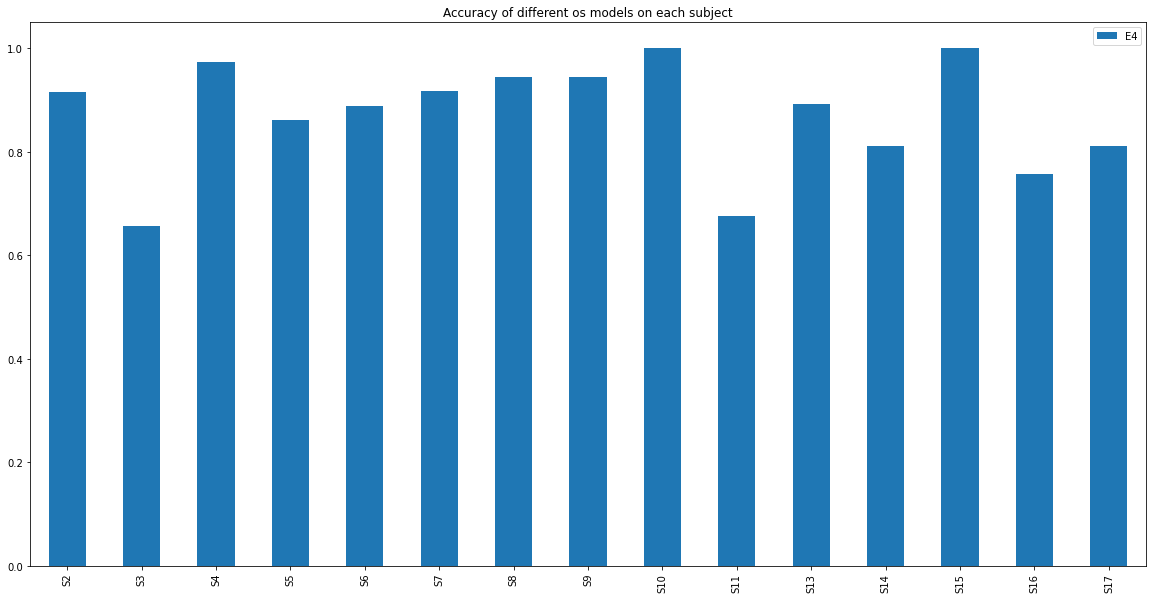

time: 295 ms (started: 2022-12-01 15:47:15 +00:00)


In [ ]:
df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

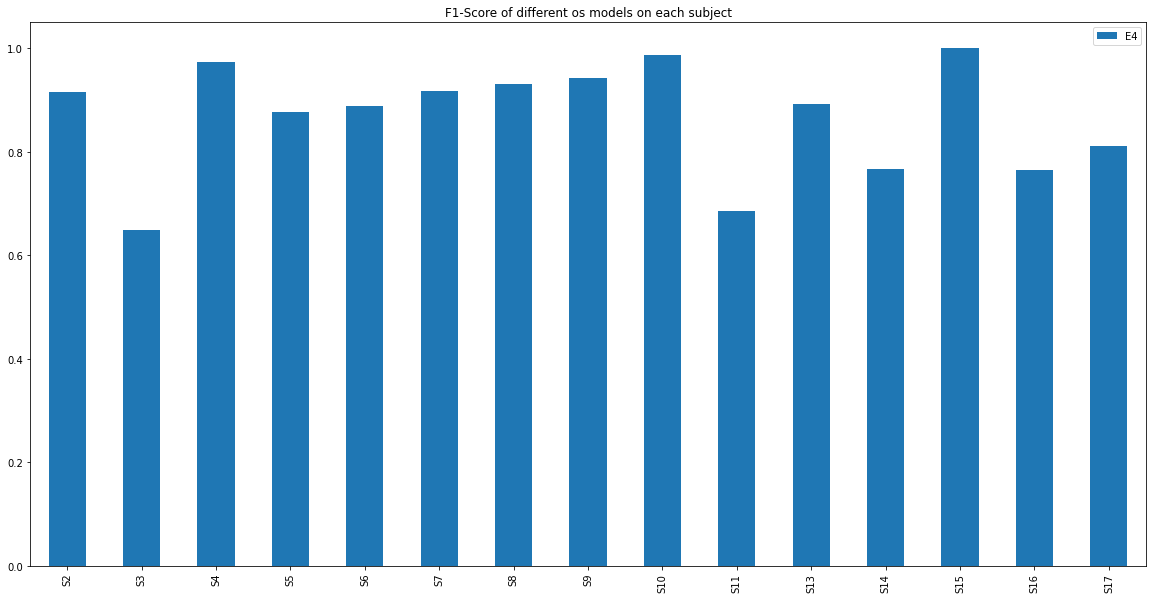

time: 237 ms (started: 2022-12-01 15:47:29 +00:00)


In [ ]:
df_os_scores_f1.plot.bar(figsize=(20,10), title='F1-Score of different os models on each subject')

           E4
S2   0.914286
S3   0.657143
S4   0.972222
S5   0.861111
S6   0.888889
S7   0.916667
S8   0.944444
S9   0.944444
S10  1.000000
S11  0.675676
S13  0.891892
S14  0.810811
S15  1.000000
S16  0.756757
S17  0.810811

E4    0.869677
dtype: float64



Text(0.5, 1.0, 'Average accuracy of different models on each OS')

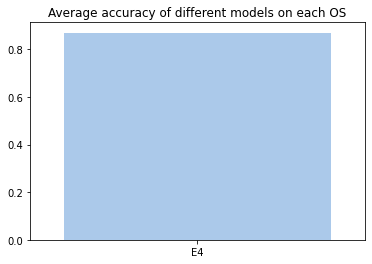

time: 106 ms (started: 2022-12-01 15:47:33 +00:00)


In [ ]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_acc}\n')
print(f'{df_os_scores_acc.mean()}\n')
sns.barplot(x=df_os_scores_acc.keys(), y=df_os_scores_acc.mean(), palette='pastel').set_title(label='Average accuracy of different models on each OS')

           E4
S2   0.914286
S3   0.647887
S4   0.972222
S5   0.876712
S6   0.888889
S7   0.916667
S8   0.931507
S9   0.942857
S10  0.986301
S11  0.684932
S13  0.891892
S14  0.767123
S15  1.000000
S16  0.764706
S17  0.810811

E4    0.866453
dtype: float64



Text(0.5, 1.0, 'F1 score of different models on each OS')

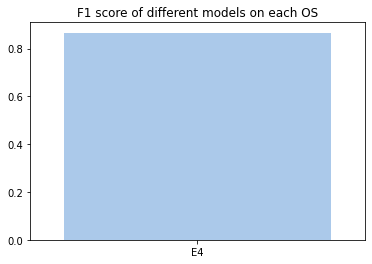

time: 98.6 ms (started: 2022-12-01 15:47:38 +00:00)


In [ ]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_f1}\n')
print(f'{df_os_scores_f1.mean()}\n')
sns.barplot(x=df_os_scores_f1.keys(), y=df_os_scores_f1.mean(), palette='pastel').set_title(label='F1 score of different models on each OS')

# Visualisierung

In [ ]:
from skimage import data, io
from skimage.color import rgb2gray

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix

from datetime import datetime



In [ ]:
model_path = checkpoint_prepath + f'/E4/wesad_E4_binary_s2_100.h5'
    
model = tf.keras.models.load_model(model_path)

viz_path = os.path.realpath("/content/drive/MyDrive/Masterarbeit/Visualizations/")

In [ ]:
now = datetime.now() # current date and time
tf.keras.utils.plot_model(model,to_file= viz_path + "/" + now.strftime("%d.%m.%Y,%H:%M:%S") + "model.png",show_shapes=True,show_dtype=False,show_layer_names=True,rankdir="TB",expand_nested=True,dpi=96,layer_range=None,show_layer_activations=True,)

# Prediction

In [ ]:
model_path = checkpoint_prepath + "/E4/wesad_E4_binary_s3_100.h5"
model = tf.keras.models.load_model(model_path)
predictions = model.predict(X_test) # make predictions on the test set using the trained model
pred_class = np.argmax(predictions, axis=-1) # get the class with the highest probability

2/2 [==============================] - 0s 8ms/step
time: 2.17 s (started: 2022-12-01 15:48:11 +00:00)


In [ ]:
true_classified = 0
for i in range(len(pred_class)):
    print("Prediction: ", predictions[i])
    print("Prediction: ", pred_class[i])
    ground_truth = max(enumerate(y_test[i]),key=lambda x: x[1])[0]
    print("Ground Truth: ", ground_truth)
    print()
    if ground_truth == pred_class[i]:
        true_classified += 1
print("Accuracy: ", true_classified/len(pred_class))
    

Prediction:  [0.05376294 0.946237  ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.14727362 0.8527264 ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.49108317 0.5089168 ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.5124798  0.48752025]
Prediction:  0
Ground Truth:  0

Prediction:  [0.59520155 0.40479842]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7115342  0.28846586]
Prediction:  0
Ground Truth:  0

Prediction:  [0.71345866 0.28654134]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7827384  0.21726164]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7670083  0.23299167]
Prediction:  0
Ground Truth:  0

Prediction:  [0.8456738 0.1543262]
Prediction:  0
Ground Truth:  0

Prediction:  [0.92748475 0.07251529]
Prediction:  0
Ground Truth:  0

Prediction:  [0.94936615 0.05063385]
Prediction:  0
Ground Truth:  0

Prediction:  [0.80464286 0.19535708]
Prediction:  0
Ground Truth:  0

Prediction:  [0.90086085 0.09913921]
Prediction:  0
Ground Truth:  0

Prediction:  [0.979484